# MNIST classification using LeNet

In [1]:
import warnings
from pathlib import Path

import matplotlib.patches as patches
import numpy as np
import pytorch_hyperlight as pth
import pytorch_lightning as pl
import pytorch_lightning.metrics as metrics
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from pytorch_lightning import Callback
from IPython.display import display
from ray import tune
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets.mnist import MNIST
from transformers import AdamW, get_linear_schedule_with_warmup

/home/peter/.conda/envs/pth0/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
USAGE_MODE_LIST = ["single-run", "hyper-opt"]  # choose from 'single-run' and 'hyper-opt'
# USAGE_MODE_LIST = ["hyper-opt"]
# USAGE_MODE_LIST = ["single-run"]
FAST_DEV_RUN = False  # if true, simplifed configurations running for just a few epochs are used for making sure there are no obvious bugs

In [3]:
EXPERIMENT_ID = "boring-mnist"

DATASETS_PATH = Path.cwd()

warnings.filterwarnings("ignore")


# a dedicated function for creating datasets
# please note how 'full_train_dataset' is created along with train,
# val and test datasets
def create_datasets(val_size=0.2):
    SEED = 16
    pl.seed_everything(SEED)
    #
    full_train_dataset = MNIST(
        DATASETS_PATH, train=True, download=True, transform=transforms.ToTensor()
    )
    test_dataset = MNIST(
        DATASETS_PATH, train=False, download=True, transform=transforms.ToTensor()
    )
    n_full_train_samples = len(full_train_dataset)
    n_val_samples = int(n_full_train_samples * val_size)
    train_dataset, val_dataset = random_split(
        full_train_dataset, [n_full_train_samples - n_val_samples, n_val_samples]
    )

    n_classes = len(MNIST.classes)

    return {
        "full_train_dataset": full_train_dataset,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
        "n_classes": n_classes,
    }

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
# a dedicated function for creating dataloaders
# 'full_train_loader' is created along with standard 3 loaderers
# for training, validation and testing datasets
def configure_dataloaders(batch_size, n_workers=4, val_size=0.2):
    #
    SHUFFLE = True
    SAMPLER = None
    #
    result_dict = create_datasets(val_size)
    #
    for prefix in ["train", "full_train"]:

        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=SHUFFLE,
            sampler=SAMPLER,
            num_workers=n_workers,
            pin_memory=True,
        )
    #
    for prefix in ["val", "test"]:
        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=n_workers,
            pin_memory=True,
        )

    return result_dict

Let us make sure our dataloaders can be created correctly

In [6]:
BATCH_SIZE = 32

loaders_dict = configure_dataloaders(BATCH_SIZE)

loaders_dict

batch = next(iter(loaders_dict["train_loader"]))
assert len(batch[0]) > 0

In [7]:
result_dict = create_datasets(0.2)
len(result_dict["full_train_dataset"])

60000

In [8]:
loaders_dict["n_classes"]

10

### Defining the model

Let define a dedicated class for metrics calculation

In [9]:
class LitMetricsCalc(torch.nn.Module):
    def __init__(self, prefix, num_classes):
        super(LitMetricsCalc, self).__init__()
        self.acc = metrics.classification.Accuracy()
        self.f1 = metrics.classification.F1(num_classes=num_classes, average="macro")
        self.prefix = prefix

    def step(self, logit, target):
        probs = torch.softmax(logit, dim=1)
        prefix = self.prefix
        self.acc(probs, target)
        self.f1(probs, target)

        return {
            f"{prefix}_acc": self.acc,
            f"{prefix}_f1": self.f1,
        }

In [10]:
class LeNetBoringMNIST(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
class LitBoringMNIST(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        #
        n_classes = self.hparams.n_classes
        #
        model = LeNetBoringMNIST(n_classes)
        #
        self.model = model
        self.train_metric_calc = LitMetricsCalc("train", num_classes=n_classes)
        self.val_metric_calc = LitMetricsCalc("val", num_classes=n_classes)
        self.test_metric_calc = LitMetricsCalc("test", num_classes=n_classes)
        self.freeze()

    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_tail(self, ind_layer):
        assert ind_layer >= 0
        ind = ind_layer
        while True:
            if ind == 0:
                for param in self.model.fc3.parameters():
                    param.requires_grad = True
            elif ind == 1:
                for param in self.model.fc2.parameters():
                    param.requires_grad = True
            elif ind == 2:
                for param in self.model.fc1.parameters():
                    param.requires_grad = True
            ind -= 1
            if ind < 0:
                break

    def configure_optimizers(self):
        optimizer = AdamW(
            self.model.parameters(),
            lr=self.hparams.lr,
        )

        scheduler = get_linear_schedule_with_warmup(
            optimizer, self.hparams.warmup, self.hparams.n_train_steps
        )
        return [optimizer], [
            {"scheduler": scheduler, "interval": "step", "frequency": 1}
        ]

    def forward(self, inputs):
        logits = self.model(inputs)
        return logits

    def forward_batch(self, batch):
        inputs = batch[0]
        return self(inputs)

    def __calc_loss(self, logits, target, log_label):
        loss = F.cross_entropy(logits, target)
        self.log(f"{log_label}_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def __stage_step(self, metric_calc, batch, batch_idx, stage):
        logits = self.forward_batch(batch)
        mval_dict = metric_calc.step(logits, batch[1])
        self.log_dict(mval_dict, prog_bar=True, on_step=True, on_epoch=True)
        loss = self.__calc_loss(logits, batch[1], stage)
        return loss

    def training_step(self, batch, batch_idx):
        return self.__stage_step(self.train_metric_calc, batch, batch_idx, "train")

    def test_step(self, batch, batch_idx):
        return self.__stage_step(self.test_metric_calc, batch, batch_idx, "test")

    def validation_step(self, batch, batch_idx):
        return self.__stage_step(self.val_metric_calc, batch, batch_idx, "val")

In [12]:
N_CLASSES = loaders_dict["n_classes"]
LMODULE_CLASS = LitBoringMNIST
IS_CUDA = torch.cuda.is_available()
GPU_PER_TRIAL = 0.3 * IS_CUDA

In [13]:
CONFIG = {
    "lr": 1e-3,  # Initial learning rate
    "warmup": 200,  # For LinearSchedulerWihtWarmup
    "gradient_clip_val": 0,
    "max_epochs": 6,  # the actual number can be less due to early stopping
    "batch_size": 64,
    "n_classes": N_CLASSES,
    "unfreeze_epochs": [0, 1]  # 2-phase unfreeze,
    #    unfreeze the tip of the tail at the start of epoch 0,
    #    then unfreeze one more layer at epoch 1,
}

TUNE_CONFIG = {
    "seed": 16,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # for Ray Tune
    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 6,  # for both PTL Trainer and Ray Tune scheduler
    "epoch_upper_limit": 45,  # for Ray Tune
    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 7,  # for PTL Trainer
    "ptl_precision": 32,  # or 16, for PTL Trainer
    "train_loader_name": "train_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    TUNE_CONFIG["n_samples"] = 2

In [14]:
class UnfreezeModelTailCallback(Callback):
    def __init__(self, epoch_vec):
        super().__init__()
        self.epoch_vec = epoch_vec

    def on_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch <= self.epoch_vec[0]:
            pl_module.unfreeze_tail(0)
        elif trainer.current_epoch <= self.epoch_vec[1]:
            pl_module.unfreeze_tail(1)
        else:
            pl_module.unfreeze()


pl_callbacks = [UnfreezeModelTailCallback(CONFIG["unfreeze_epochs"])]

In [15]:
runner = pth.Runner(
    configure_dataloaders,
    pl_callbacks=pl_callbacks,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False
)

#### Run a single trial (train-validation-test cycle)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | LeNetBoringMNIST | 60.1 K
1 | train_metric_calc | LitMetricsCalc   | 0     
2 | val_metric_calc   | LitMetricsCalc   | 0     
3 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
0         Trainable params
60.1 K    Non-trainable params
60.1 K    Total params


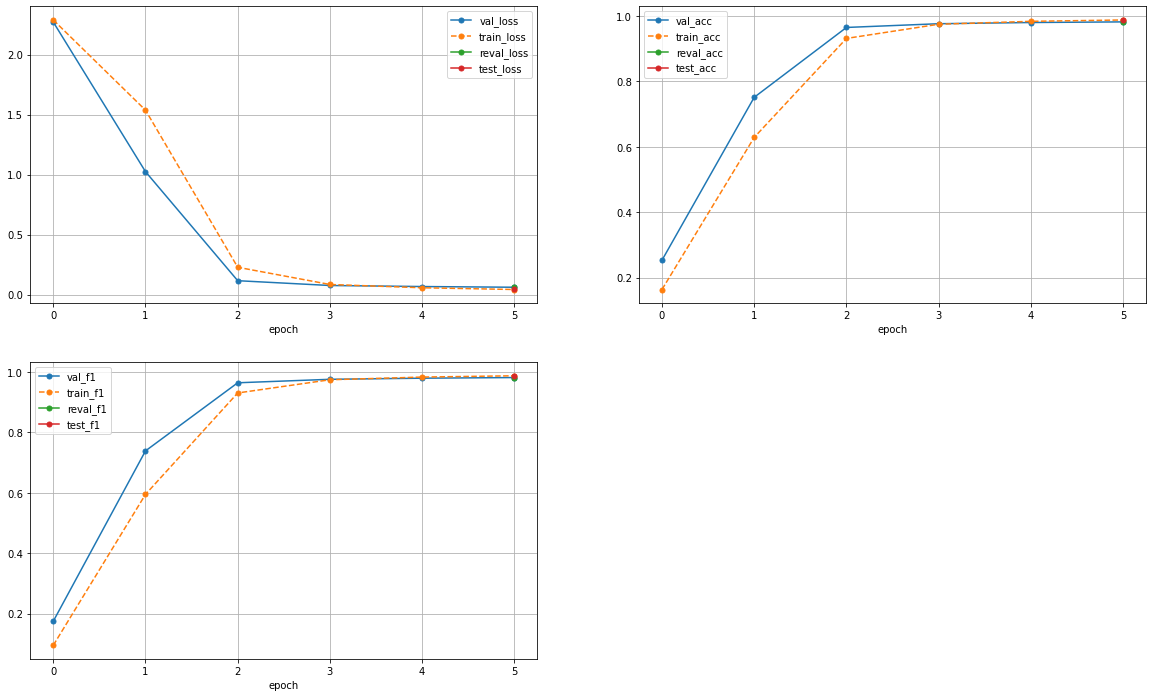

In [16]:
if "single-run" in USAGE_MODE_LIST:
    best_result = runner.run_single_trial(LMODULE_CLASS, CONFIG, TUNE_CONFIG)

#### Let us look at the resulting metrics timeseries in a tabular form

In [17]:
if "single-run" in USAGE_MODE_LIST:
    display(best_result["metrics"].df)

,stage,epoch,stage-list,val_f1,train_f1,val_acc,train_acc,val_loss,train_loss,reval_f1,reval_acc,reval_loss,test_f1,test_acc,test_loss
0,Train/Val,0,"(train, val)",0.1747,0.0951,0.2534,0.1639,2.2725,2.2897,NaN,NaN,NaN,NaN,NaN,NaN
1,Train/Val,1,"(train, val)",0.7387,0.5947,0.7512,0.6287,1.0247,1.5376,NaN,NaN,NaN,NaN,NaN,NaN
2,Train/Val,2,"(train, val)",0.9642,0.9305,0.9646,0.9311,0.1153,0.2273,NaN,NaN,NaN,NaN,NaN,NaN
3,Train/Val,3,"(train, val)",0.9757,0.9742,0.9760,0.9744,0.0753,0.0837,NaN,NaN,NaN,NaN,NaN,NaN
4,Train/Val,4,"(train, val)",0.9794,0.9831,0.9797,0.9833,0.0666,0.0564,NaN,NaN,NaN,NaN,NaN,NaN
5,Train/Val,5,"(train, val)",0.9815,0.9874,0.9816,0.9875,0.0607,0.0418,NaN,NaN,NaN,NaN,NaN,NaN
6,Reval,5,"(reval,)",NaN,NaN,NaN,NaN,NaN,NaN,0.9815,0.9816,0.0607,NaN,NaN,NaN
7,Test,5,"(test,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9858,0.9859,0.0458


#### Or just look at the latest observed values for each of the metrics

In [18]:
if "single-run" in USAGE_MODE_LIST:
    display(best_result["metrics"].series_last)

val_f1        0.9815
train_f1      0.9874
val_acc       0.9816
train_acc     0.9875
val_loss      0.0607
train_loss    0.0418
reval_f1      0.9815
reval_acc     0.9816
reval_loss    0.0607
test_f1       0.9858
test_acc      0.9859
test_loss     0.0458
Name: 7, dtype: float64

#### Plot the metrics timeseries on different axis

,stage,epoch,val_f1,train_f1,val_acc,train_acc,val_loss,train_loss,reval_f1,reval_acc,reval_loss,test_f1,test_acc,test_loss
0,Train/Val,0,0.1747,0.0951,0.2534,0.1639,2.2725,2.2897,NaN,NaN,NaN,NaN,NaN,NaN
1,Train/Val,1,0.7387,0.5947,0.7512,0.6287,1.0247,1.5376,NaN,NaN,NaN,NaN,NaN,NaN
2,Train/Val,2,0.9642,0.9305,0.9646,0.9311,0.1153,0.2273,NaN,NaN,NaN,NaN,NaN,NaN
3,Train/Val,3,0.9757,0.9742,0.9760,0.9744,0.0753,0.0837,NaN,NaN,NaN,NaN,NaN,NaN
4,Train/Val,4,0.9794,0.9831,0.9797,0.9833,0.0666,0.0564,NaN,NaN,NaN,NaN,NaN,NaN
5,Train/Val,5,0.9815,0.9874,0.9816,0.9875,0.0607,0.0418,NaN,NaN,NaN,NaN,NaN,NaN
6,Reval,5,NaN,NaN,NaN,NaN,NaN,NaN,0.9815,0.9816,0.0607,NaN,NaN,NaN
7,Test,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9858,0.9859,0.0458


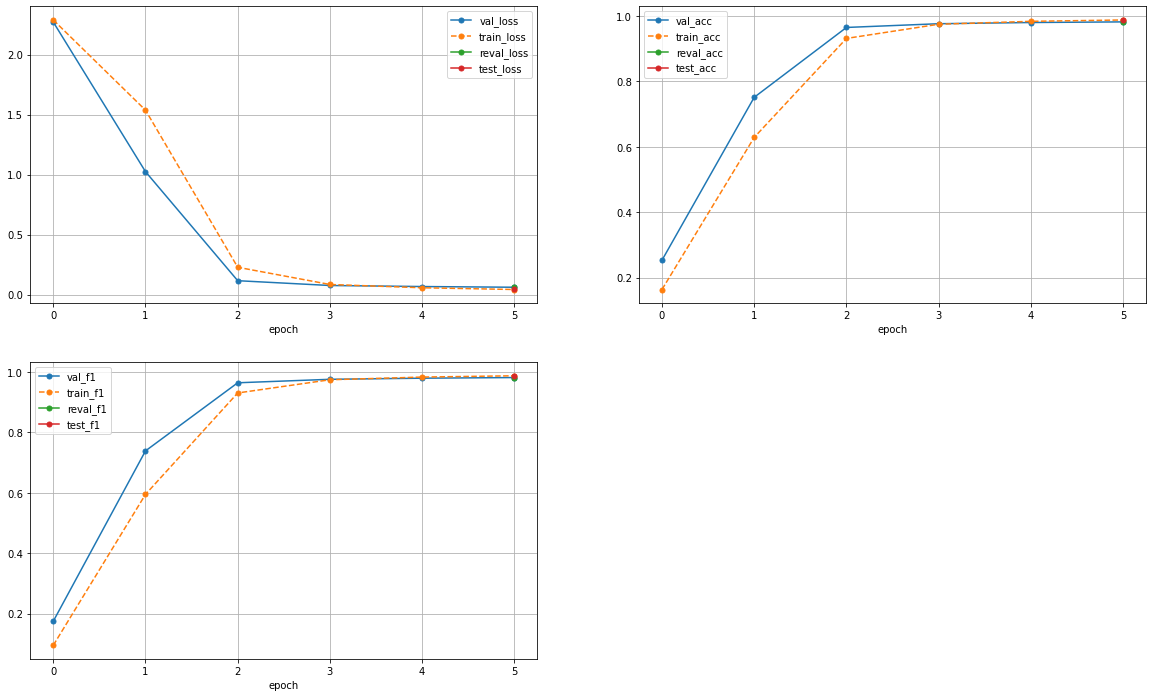

In [19]:
if "single-run" in USAGE_MODE_LIST:
    best_result["metrics"].show_report()

### Running a hyper-parameters search via Ray Tune

In [20]:
SEARCH_SPACE_CONFIG = {
    "unfreeze_epochs": [0, 1],
    "lr": tune.uniform(1e-4, 1e-3),
    "warmup": tune.choice([200, 500, 600, 1000]),
    "gradient_clip_val": 0,
    "max_epochs": tune.choice([6]),
    "batch_size": tune.choice([16, 32, 64]),
    "n_classes": N_CLASSES,
}

In [21]:
if FAST_DEV_RUN:
    SEARCH_SPACE_CONFIG["max_epochs"] = 2
    SEARCH_SPACE_CONFIG["batch_size"] = 32

2021-01-20 14:46:40,443	INFO services.py:1171 -- View the Ray dashboard at http://192.168.1.135:8265


== Status ==
Memory usage on this node: 17.8/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 18.000: None | Iter 6.000: None
Resources requested: 3/12 CPUs, 0.0/0 GPUs, 0.0/10.01 GiB heap, 0.0/3.42 GiB objects
Result logdir: /home/peter/ray_results/boring-mnist_20_Jan_2021_14_46_41
Number of trials: 1/3 (1 RUNNING)
+----------------+----------+-------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------+
| Trial name     | status   | loc   | unfreeze_epochs   |          lr |   warmup |   gradient_clip_val |   max_epochs |   batch_size |   n_classes |
|----------------+----------+-------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------|
| inner_2966536a | RUNNING  |       | (0, 1)            | 0.000993607 |      600 |                   0 |            6 |           32 |          10 |
+----------------+----------+-------+-------------------+-------------+-----

2021-01-20 14:47:53,850	INFO logger.py:293 -- Removed the following hyperparameter values when logging to tensorboard: {'unfreeze_epochs': (0, 1)}
2021-01-20 14:47:54,604	INFO logger.py:293 -- Removed the following hyperparameter values when logging to tensorboard: {'unfreeze_epochs': (0, 1)}


== Status ==
Memory usage on this node: 18.4/31.3 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 18.000: None | Iter 6.000: 0.9675515492757161
Resources requested: 3/12 CPUs, 0.0/0 GPUs, 0.0/10.01 GiB heap, 0.0/3.42 GiB objects
Current best trial: 2966536a with val_f1_epoch=0.9840981364250183 and parameters={'unfreeze_epochs': (0, 1), 'lr': 0.0009936073824648494, 'warmup': 600, 'gradient_clip_val': 0, 'max_epochs': 6, 'batch_size': 32, 'n_classes': 10}
Result logdir: /home/peter/ray_results/boring-mnist_20_Jan_2021_14_46_41
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+----------------+------------+-----------------------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------+------------------+----------------+-----------------+----------------------+
| Trial name     | status     | loc                   | unfreeze_epochs   |          lr |   warmup |   gradient_clip_val |   max_epochs |   batch_size |   n_classes |   va

2021-01-20 14:48:19,431	INFO logger.py:293 -- Removed the following hyperparameter values when logging to tensorboard: {'unfreeze_epochs': (0, 1)}
2021-01-20 14:48:19,442	INFO tune.py:448 -- Total run time: 98.32 seconds (98.28 seconds for the tuning loop).


== Status ==
Memory usage on this node: 18.5/31.3 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 18.000: None | Iter 6.000: 0.9761589368184407
Resources requested: 3/12 CPUs, 0.0/0 GPUs, 0.0/10.01 GiB heap, 0.0/3.42 GiB objects
Current best trial: 2966536a with val_f1_epoch=0.9854029417037964 and parameters={'unfreeze_epochs': (0, 1), 'lr': 0.0009936073824648494, 'warmup': 600, 'gradient_clip_val': 0, 'max_epochs': 6, 'batch_size': 32, 'n_classes': 10}
Result logdir: /home/peter/ray_results/boring-mnist_20_Jan_2021_14_46_41
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+----------------+------------+-----------------------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------+------------------+----------------+-----------------+----------------------+
| Trial name     | status     | loc                   | unfreeze_epochs   |          lr |   warmup |   gradient_clip_val |   max_epochs |   batch_size |   n_classes |   va

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


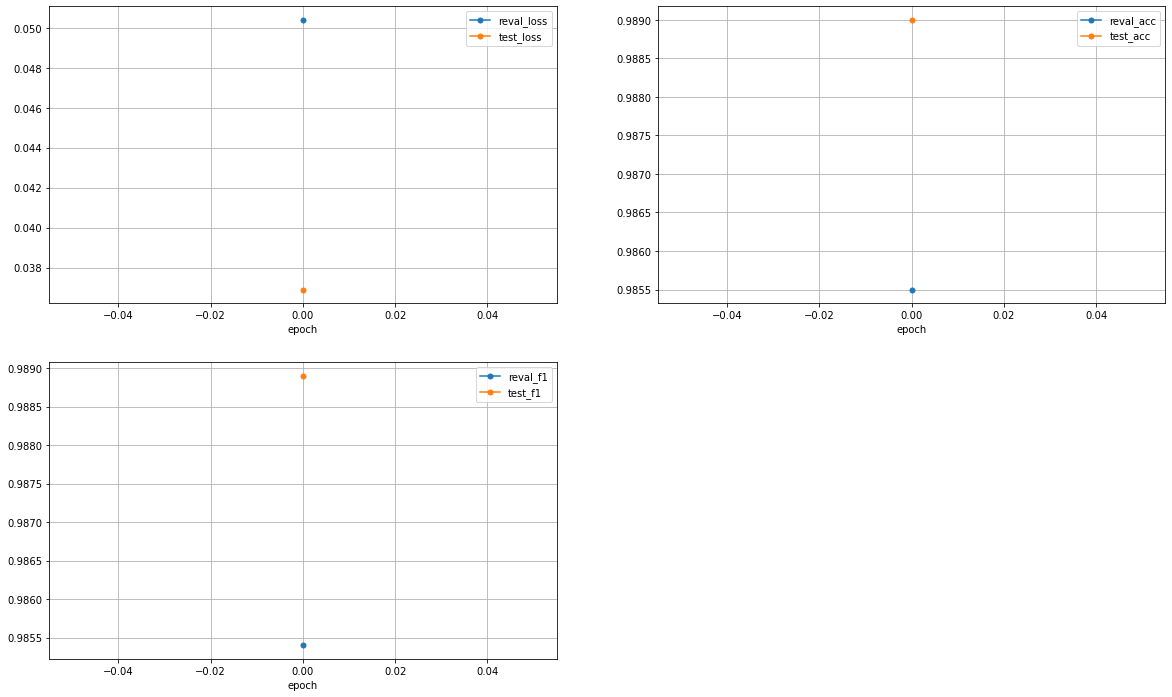

In [22]:
if "hyper-opt" in USAGE_MODE_LIST:
    best_result = runner.run_hyper_opt(
        LMODULE_CLASS,
        SEARCH_SPACE_CONFIG,
        TUNE_CONFIG,
    )
    best_result["metrics"].df

### Let us look at the results

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [25]:
def show_some_predictions(loaders_dict, lmodule):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, 1000))
        im_val, label = loaders_dict["val_dataset"][random_characters]
        img_label = " ".join(
            map(
                lambda x: x.capitalize(),
                MNIST.classes[label].split("_"),
            )
        )

        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

        fig_x.add_patch(patches.Rectangle((0, 0), 10, 5, color="white"))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("fantasy")
        prob_pred = predict_one_sample(lmodule, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred) * 100
        y_pred = np.argmax(prob_pred)

        predicted_label = MNIST.classes[y_pred]
        predicted_label = (
            predicted_label[: len(predicted_label) // 2]
            + "\n"
            + predicted_label[len(predicted_label) // 2 :]
        )
        predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)

        fig_x.text(
            1,
            2,
            predicted_text,
            horizontalalignment="left",
            fontproperties=font,
            verticalalignment="top",
            fontsize=8,
            color="black",
            fontweight="bold",
        )

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs, _ in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

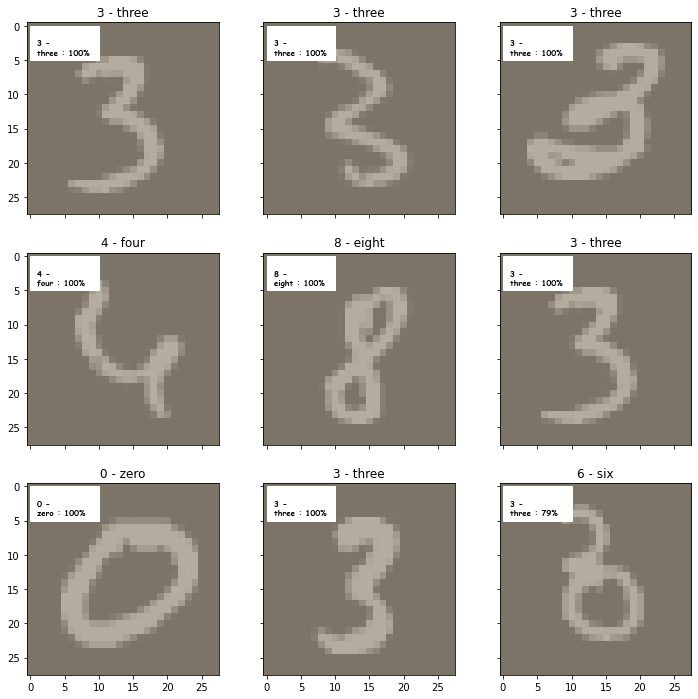

In [27]:
show_some_predictions(loaders_dict, best_result["lmodule_best"])

### Re-train the model on all available data with the same hyper-parameters

In [28]:
FT_TUNE_CONFIG = TUNE_CONFIG.copy()
FT_TUNE_CONFIG["val_loader_name"] = None
FT_TUNE_CONFIG["train_loader_name"] = "full_train_loader"
FT_TUNE_CONFIG["metric_to_optimize"] = "train_f1_epoch"

In [29]:
FT_CONFIG = CONFIG.copy()
# Train for a number of epochs found to be optimal during the hyper-parameter search
FT_CONFIG["max_epochs"] = best_result["best_epoch"]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | LeNetBoringMNIST | 60.1 K
1 | train_metric_calc | LitMetricsCalc   | 0     
2 | val_metric_calc   | LitMetricsCalc   | 0     
3 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
0         Trainable params
60.1 K    Non-trainable params
60.1 K    Total params


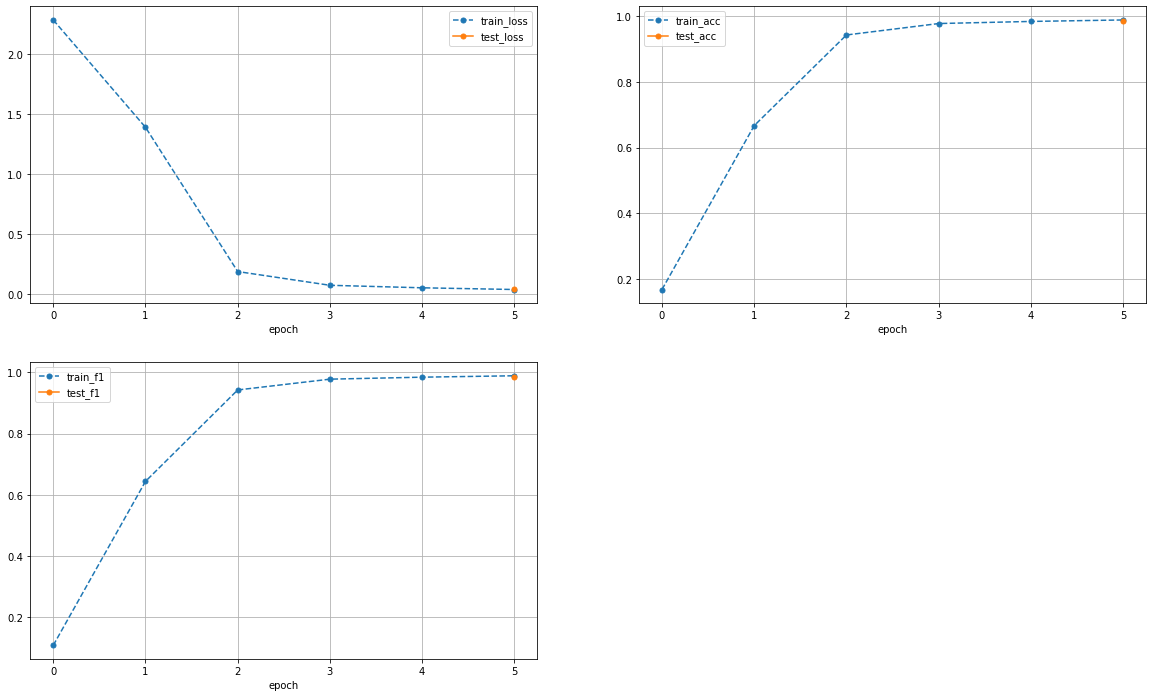

In [30]:
full_train_result = runner.run_single_trial(
    LMODULE_CLASS,
    FT_CONFIG,
    FT_TUNE_CONFIG,
)

### Look at prediction results again

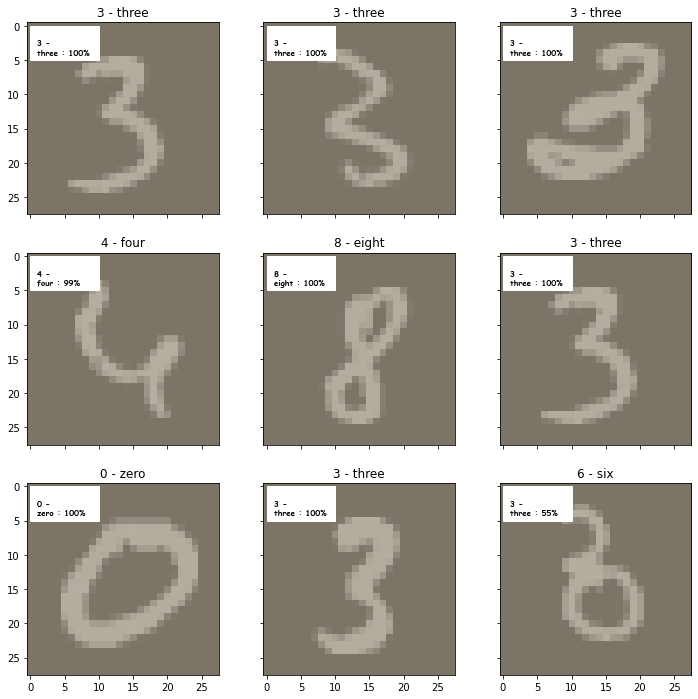

In [31]:
show_some_predictions(loaders_dict, full_train_result["lmodule_best"])

### Show the report comparing the single run and the result of hyper-parameter optimization

,test_f1,test_acc,test_loss,run
1,0.9889,0.9890,0.0369,hyper-opt-LitBoringMNIST
6,0.9859,0.9860,0.0411,single-trial-LitBoringMNIST@2
7,0.9858,0.9859,0.0458,single-trial-LitBoringMNIST


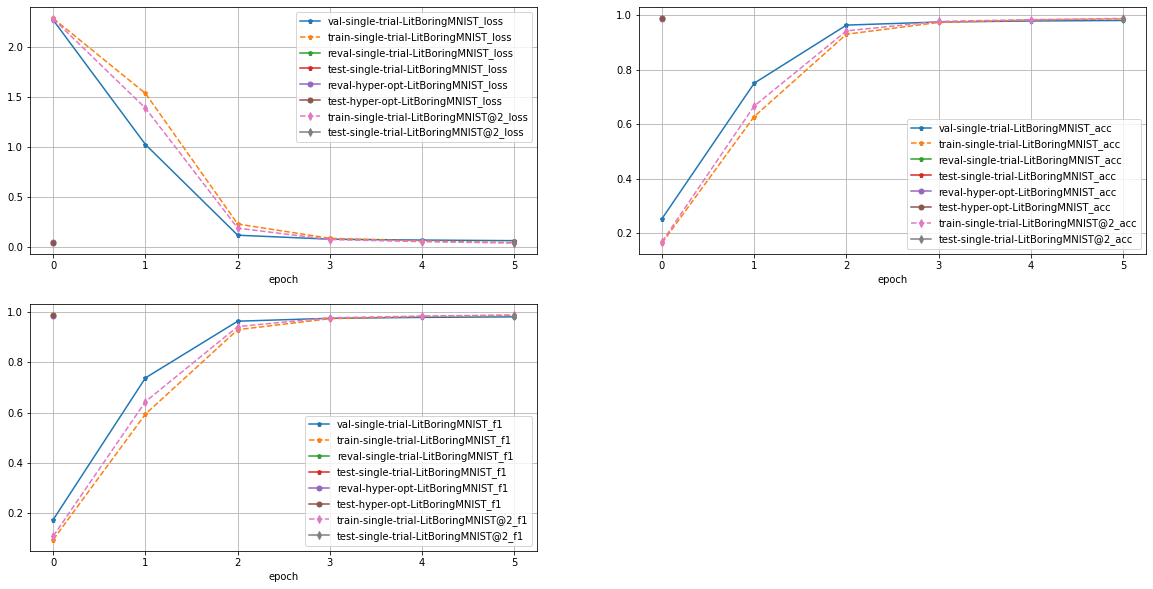

In [32]:
runner.show_metric_report(sort_by_metric_list=['test_f1', 'test_acc', "test_loss"])

### Get the last observed metrics for both single-run and hyper-parameter optimization as Pandas DataFrame

In [33]:
runner.get_metrics()['run_x_last_metric_df']

,val_f1,train_f1,val_acc,train_acc,val_loss,train_loss,reval_f1,reval_acc,reval_loss,test_f1,test_acc,test_loss,run
7,0.9815,0.9874,0.9816,0.9875,0.0607,0.0418,0.9815,0.9816,0.0607,0.9858,0.9859,0.0458,single-trial-LitBoringMNIST
1,NaN,NaN,NaN,NaN,NaN,NaN,0.9854,0.9855,0.0504,0.9889,0.9890,0.0369,hyper-opt-LitBoringMNIST
6,NaN,0.9891,NaN,0.9891,NaN,0.0365,NaN,NaN,NaN,0.9859,0.9860,0.0411,single-trial-LitBoringMNIST@2


### Get the time-series metrics for both single-run and hyper-parameter optimization as Pandas DataFrame

In [34]:
runner.get_metrics()['epoch_x_stage_run_metric'].df

,stage,epoch,stage-list,val-single-trial-LitBoringMNIST_f1,train-single-trial-LitBoringMNIST_f1,val-single-trial-LitBoringMNIST_acc,train-single-trial-LitBoringMNIST_acc,val-single-trial-LitBoringMNIST_loss,train-single-trial-LitBoringMNIST_loss,reval-single-trial-LitBoringMNIST_f1,...,reval-hyper-opt-LitBoringMNIST_loss,test-hyper-opt-LitBoringMNIST_f1,test-hyper-opt-LitBoringMNIST_acc,test-hyper-opt-LitBoringMNIST_loss,train-single-trial-LitBoringMNIST@2_f1,train-single-trial-LitBoringMNIST@2_acc,train-single-trial-LitBoringMNIST@2_loss,test-single-trial-LitBoringMNIST@2_f1,test-single-trial-LitBoringMNIST@2_acc,test-single-trial-LitBoringMNIST@2_loss
0,Train/Val,0,"(train, val)",0.1747,0.0951,0.2534,0.1639,2.2725,2.2897,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Train/Val,1,"(train, val)",0.7387,0.5947,0.7512,0.6287,1.0247,1.5376,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Train/Val,2,"(train, val)",0.9642,0.9305,0.9646,0.9311,0.1153,0.2273,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Train/Val,3,"(train, val)",0.9757,0.9742,0.9760,0.9744,0.0753,0.0837,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Train/Val,4,"(train, val)",0.9794,0.9831,0.9797,0.9833,0.0666,0.0564,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Train/Val,5,"(train, val)",0.9815,0.9874,0.9816,0.9875,0.0607,0.0418,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Reval,5,"(reval,)",NaN,NaN,NaN,NaN,NaN,NaN,0.9815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Test,5,"(test,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9859,0.986,0.0411
8,Reval,0,"(reval,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Test,0,"(test,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.9889,0.989,0.0369,NaN,NaN,NaN,NaN,NaN,NaN
